In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install patchify

In [3]:
!pip install imagecodecs

     |████████████████████████████████| 29.6 MB 71.0 MB/s 


In [1]:
import os
import cv2
import numpy as np
import skimage.io
from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
from PIL import Image
import tifffile as tiff
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras import backend as K
from sklearn.metrics import jaccard_score,confusion_matrix

np.random.seed(0)

In [2]:
def IoU_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def IoU_loss(y_true, y_pred):
    return -IoU_coef(y_true, y_pred)
 
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)
 
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
  
def accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true.flatten(),y_pred.flatten(), labels=[0, 1])
    acc = (cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])
    return acc
  
def IoU(y_true, y_pred, labels = [0, 1]):
   IoU = []
   for label in labels:
      jaccard = jaccard_score(y_pred.flatten(),y_true.flatten(), pos_label=label, average='weighted')
      IoU.append(jaccard)     
   return np.mean(IoU)

In [3]:
#convolutional block
def conv_block(x, kernelsize, filters, dropout, batchnorm=False): 
    conv = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(x)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)
    conv = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(conv)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    return conv


#residual convolutional block
def res_conv_block(x, kernelsize, filters, dropout, batchnorm=False):
    conv1 = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding='same')(x)
    if batchnorm is True:
        conv1 = layers.BatchNormalization(axis=3)(conv1)
    conv1 = layers.Activation('relu')(conv1)    
    conv2 = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding='same')(conv1)
    if batchnorm is True:
        conv2 = layers.BatchNormalization(axis=3)(conv2)
        conv2 = layers.Activation("relu")(conv2)
    if dropout > 0:
        conv2 = layers.Dropout(dropout)(conv2)
        
    #skip connection    
    shortcut = layers.Conv2D(filters, kernel_size=(1, 1), kernel_initializer='he_normal', padding='same')(x)
    if batchnorm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)
    shortcut = layers.Activation("relu")(shortcut)
    respath = layers.add([shortcut, conv2])       
    return respath


#gating signal for attention unit
def gatingsignal(input, out_size, batchnorm=False):
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x


<h3><center>U-NET Architecture</center></h3>

In [4]:
#Simple U-NET
def unetmodel(input_shape, dropout=0.2, batchnorm=True):    
    
    filters = [16, 32, 64, 128, 256]
    kernelsize = 3
    upsample_size = 2
    
    inputs = layers.Input(input_shape)    

    # Downsampling layers
    dn_1 = conv_block(inputs, kernelsize, filters[0], dropout, batchnorm)
    pool_1 = layers.MaxPooling2D(pool_size=(2,2))(dn_1)
    
    dn_2 = conv_block(pool_1, kernelsize, filters[1], dropout, batchnorm)
    pool_2 = layers.MaxPooling2D(pool_size=(2,2))(dn_2)
    
    dn_3 = conv_block(pool_2, kernelsize, filters[2], dropout, batchnorm)
    pool_3 = layers.MaxPooling2D(pool_size=(2,2))(dn_3)
    
    dn_4 = conv_block(pool_3, kernelsize, filters[3], dropout, batchnorm)
    pool_4 = layers.MaxPooling2D(pool_size=(2,2))(dn_4)
    
    dn_5 = conv_block(pool_4, kernelsize, filters[4], dropout, batchnorm)

    # Upsampling layers   
    up_5 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(dn_5)
    up_5 = layers.concatenate([up_5, dn_4], axis=3)
    up_conv_5 = conv_block(up_5, kernelsize, filters[3], dropout, batchnorm)
    
    up_4 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_5)
    up_4 = layers.concatenate([up_4, dn_3], axis=3)
    up_conv_4 = conv_block(up_4, kernelsize, filters[2], dropout, batchnorm)
       
    up_3 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_4)
    up_3 = layers.concatenate([up_3, dn_2], axis=3)
    up_conv_3 = conv_block(up_3, kernelsize, filters[1], dropout, batchnorm)
    
    up_2 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_3)
    up_2 = layers.concatenate([up_2, dn_1], axis=3)
    up_conv_2 = conv_block(up_2, kernelsize, filters[0], dropout, batchnorm)    
   
    conv_final = layers.Conv2D(1, kernel_size=(1,1))(up_conv_2)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    outputs = layers.Activation('sigmoid')(conv_final)  

    model = models.Model(inputs=[inputs], outputs=[outputs])
    #model.summary()        
    return model

<h3><center>Train the Model</center></h3>

In [10]:
#CLAHE
def clahe_equalized(imgs):    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))    
    imgs_equalized = clahe.apply(imgs)
    return imgs_equalized


path1 = 'drive/MyDrive/Datasets/STARE/Training/Images' #training images directory
path2 = 'drive/MyDrive/Datasets/STARE/Training/Labels' #training masks directory

image_dataset = []
mask_dataset = [] 
myList = [".jpg",".ppm","png","jpeg","JPG","gif","tif"]

patch_size = 512

images = sorted(os.listdir(path1)) 
for i, image_name in enumerate(images): 
   if image_name.endswith(tuple(myList)): 
       #image = tiff.imread(path1+"/"+image_name)
       image = skimage.io.imread(path1+"/"+image_name)  #Read image
       image = image[:,:,1] #selecting green channel
       image = clahe_equalized(image) #applying CLAHE
       SIZE_X = (image.shape[1]//patch_size)*patch_size #getting size multiple of patch size
       SIZE_Y = (image.shape[0]//patch_size)*patch_size #getting size multiple of patch size
       image = Image.fromarray(image)        
       image = image.resize((SIZE_X, SIZE_Y)) #resize image       
       image = np.array(image) 
       patches_img = patchify(image, (patch_size, patch_size), step=patch_size)  #create patches(patch_sizexpatch_sizex1)
            
       for i in range(patches_img.shape[0]):
           for j in range(patches_img.shape[1]):                        
               single_patch_img = patches_img[i,j,:,:]                 
               single_patch_img = (single_patch_img.astype('float32')) / 255.
               image_dataset.append(single_patch_img)

masks = sorted(os.listdir(path2)) 
for i, mask_name in enumerate(masks):  
    if mask_name.endswith(tuple(myList)):                  
        mask = skimage.io.imread(path2+"/"+mask_name)   #Read masks
        SIZE_X = (mask.shape[1]//patch_size)*patch_size #getting size multiple of patch size
        SIZE_Y = (mask.shape[0]//patch_size)*patch_size #getting size multiple of patch size
        mask = Image.fromarray(mask)        
        mask = mask.resize((SIZE_X, SIZE_Y))  #resize image
        mask = np.array(mask)
        patches_mask = patchify(mask, (patch_size, patch_size), step=patch_size)  #create patches(patch_sizexpatch_sizex1)
            
        for i in range(patches_mask.shape[0]):
            for j in range(patches_mask.shape[1]):                            
                single_patch_mask = patches_mask[i,j,:,:]
                single_patch_mask = (single_patch_mask.astype('float32'))/255. 
                mask_dataset.append(single_patch_mask) 
 
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)
image_dataset = np.expand_dims(image_dataset,axis=-1)
mask_dataset =  np.expand_dims(mask_dataset,axis=-1)


#importing models
#from model import unetmodel, residualunet, attentionunet, attention_residualunet
from tensorflow.keras.optimizers import Adam
#from evaluation_metrics import IoU_coef,IoU_loss

IMG_HEIGHT = patch_size
IMG_WIDTH = patch_size
IMG_CHANNELS = 1
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = unetmodel(input_shape)
model.compile(optimizer = Adam(lr = 1e-3), loss= IoU_loss, metrics= ['accuracy', IoU_coef])

#splitting data into 70-30 ratio to validate training performance
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size=0.3, random_state=0)

#train model
history = model.fit(x_train, y_train, 
                    verbose=1,
                    batch_size = 16,
                    validation_data=(x_test, y_test ), 
                    shuffle=False,
                    epochs=10000)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 344ms/step - loss: -0.8302 - accuracy: 0.9402 - IoU_coef: 0.8302 - val_loss: -0.6724 - val_accuracy: 0.9345 - val_IoU_coef: 0.6724
Epoch 7502/10000
1/1 [==============================] - 0s 339ms/step - loss: -0.8300 - accuracy: 0.9402 - IoU_coef: 0.8300 - val_loss: -0.6720 - val_accuracy: 0.9345 - val_IoU_coef: 0.6720
Epoch 7503/10000
1/1 [==============================] - 0s 349ms/step - loss: -0.8302 - accuracy: 0.9402 - IoU_coef: 0.8302 - val_loss: -0.6720 - val_accuracy: 0.9346 - val_IoU_coef: 0.6720
Epoch 7504/10000
1/1 [==============================] - 0s 343ms/step - loss: -0.8302 - accuracy: 0.9402 - IoU_coef: 0.8302 - val_loss: -0.6725 - val_accuracy: 0.9346 - val_IoU_coef: 0.6725
Epoch 7505/10000
1/1 [==============================] - 0s 345ms/step - loss: -0.8300 - accuracy: 0.9402 - IoU_coef: 0.8300 - val_loss: -0.6726 - val_accuracy: 0.9345 - val_IoU_coef: 0.6726
Epoch 7506/10000

<h1><center>Save The Trained Model</center></h1>

In [11]:
#save model
model.save('drive/MyDrive/Datasets/STARE/retina_Unet_epochs_10000_STARE.hdf5')

<h3><center>Plot Info About The Trained Model</center></h3>

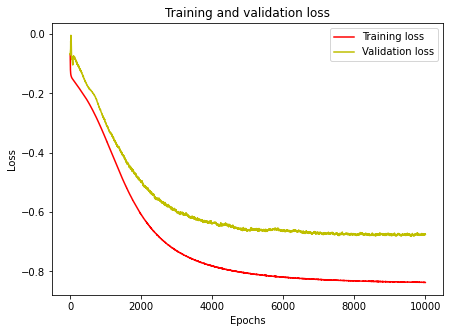

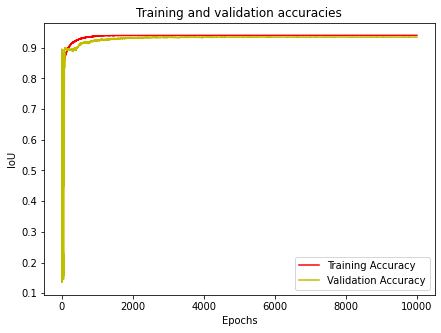

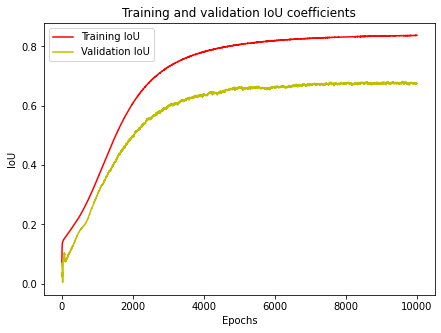

In [12]:
#training-validation loss curve
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(7,5))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#training-validation accuracy curve
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(figsize=(7,5))
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'y', label='Validation Accuracy')
plt.title('Training and validation accuracies')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

#training-validation IoU curve
iou_coef = history.history['IoU_coef']
val_iou_coef = history.history['val_IoU_coef']
plt.figure(figsize=(7,5))
plt.plot(epochs, iou_coef, 'r', label='Training IoU')
plt.plot(epochs, val_iou_coef, 'y', label='Validation IoU')
plt.title('Training and validation IoU coefficients')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

<h1><center>Load Trained Model To Make Prediction On Test Data</center></h1>

In [13]:
# CLAHE
def clahe_equalized(imgs):    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))    
    imgs_equalized = clahe.apply(imgs)
    return imgs_equalized

patch_size = 512

#loading model architectures
from tensorflow.keras.optimizers import Adam


IMG_HEIGHT = patch_size
IMG_WIDTH = patch_size
IMG_CHANNELS = 1

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = unetmodel(input_shape) 
model.compile(optimizer = Adam(lr = 1e-3), loss= IoU_loss, metrics= ['accuracy', IoU_coef])
model.load_weights('drive/MyDrive/Datasets/STARE/retina_Unet_epochs_10000_STARE.hdf5') #loading weights


path1 = 'drive/MyDrive/Datasets/STARE/Testing/Images'    #test dataset images directory path
path2 = 'drive/MyDrive/Datasets/STARE/Testing/Labels'     #test dataset mask directory path


from sklearn.metrics import jaccard_score,confusion_matrix

testimg = []
ground_truth = []
prediction = []
global_IoU = []
global_accuracy = []

testimages = sorted(os.listdir(path1))
testmasks =  sorted(os.listdir(path2))

for idx, image_name in enumerate(testimages):  
   if image_name.endswith(tuple(myList)):  
      predicted_patches = []
      test_img = skimage.io.imread(path1+"/"+image_name)
     
      test = test_img[:,:,1] #selecting green channel
      test = clahe_equalized(test) #applying CLAHE
      SIZE_X = (test_img.shape[1]//patch_size)*patch_size #getting size multiple of patch size
      SIZE_Y = (test_img.shape[0]//patch_size)*patch_size #getting size multiple of patch size
      test = cv2.resize(test, (SIZE_X, SIZE_Y))
      testimg.append(test)           
      test = np.array(test)

      patches = patchify(test, (patch_size, patch_size), step=patch_size) #create patches(patch_sizexpatch_sizex1)

      for i in range(patches.shape[0]):
                for j in range(patches.shape[1]):
                  single_patch = patches[i,j,:,:]
                  single_patch_norm = (single_patch.astype('float32')) / 255.
                  single_patch_norm = np.expand_dims(np.array(single_patch_norm), axis=-1)
                  single_patch_input = np.expand_dims(single_patch_norm, 0)
                  single_patch_prediction = (model.predict(single_patch_input)[0,:,:,0] > 0.5).astype(np.uint8) #predict on single patch
                  predicted_patches.append(single_patch_prediction)
      predicted_patches = np.array(predicted_patches)
      predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], patch_size,patch_size) )
      reconstructed_image = unpatchify(predicted_patches_reshaped, test.shape) #join patches to form whole img
      prediction.append(reconstructed_image) 

      groundtruth=[]
      groundtruth = skimage.io.imread(path2+'/'+testmasks[idx]) #reading mask of the test img      
      SIZE_X = (groundtruth.shape[1]//patch_size)*patch_size 
      SIZE_Y = (groundtruth.shape[0]//patch_size)*patch_size  
      groundtruth = cv2.resize(groundtruth, (SIZE_X, SIZE_Y))  
      ground_truth.append(groundtruth)

      y_true = groundtruth
      y_pred = reconstructed_image
      labels = [0, 1]
      IoU = []
      for label in labels:
          jaccard = jaccard_score(y_pred.flatten(),y_true.flatten(), pos_label=label, average='weighted')
          IoU.append(jaccard)
      IoU = np.mean(IoU) #jacard/IoU of single image
      global_IoU.append(IoU)

      cm=[]
      accuracy = []
      cm = confusion_matrix(y_true.flatten(),y_pred.flatten(), labels=[0, 1])
      accuracy = (cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1]) #accuracy of single image
      global_accuracy.append(accuracy)


avg_acc =  np.mean(global_accuracy)
mean_IoU = np.mean(global_IoU)

print('Average accuracy is',avg_acc)
print('mean IoU is',mean_IoU)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


Average accuracy is 0.9910745094890796
mean IoU is 0.8790894493889083


<h1><center>Visualise The Segmentation Result</center></h1>

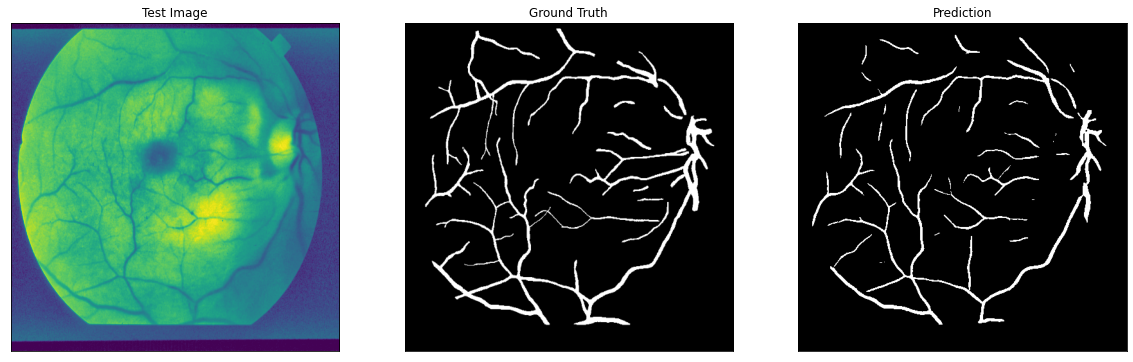

In [14]:
#checking segmentation results
import random
test_img_number = random.randint(0, len(testimg))
plt.figure(figsize=(20, 18))
plt.subplot(231)
plt.title('Test Image')
plt.xticks([])
plt.yticks([])
plt.imshow(testimg[test_img_number])
plt.subplot(232)
plt.title('Ground Truth')
plt.xticks([])
plt.yticks([])
plt.imshow(ground_truth[test_img_number],cmap='gray')
plt.subplot(233)
plt.title('Prediction')
plt.xticks([])
plt.yticks([])
plt.imshow(prediction[test_img_number],cmap='gray')

plt.show()

<h1><center>Visualise Segmentation On A Particular Image</center></h1>

Execution time:  0:00:00.046004


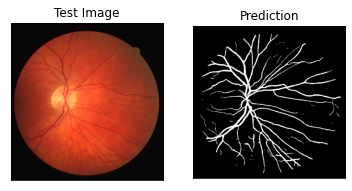

In [ ]:
#prediction on single image
from datetime import datetime 
reconstructed_image = []
test_img = skimage.io.imread('drive/MyDrive/Datasets/STARE/Testing/Images/im0004.ppm') #test image

predicted_patches = []
start = datetime.now()   

test = test_img[:,:,1] #selecting green channel
test = clahe_equalized(test) #applying CLAHE
SIZE_X = (test_img.shape[1]//patch_size)*patch_size #getting size multiple of patch size
SIZE_Y = (test_img.shape[0]//patch_size)*patch_size #getting size multiple of patch size
test = cv2.resize(test, (SIZE_X, SIZE_Y))        
test = np.array(test)
patches = patchify(test, (patch_size, patch_size), step=patch_size) #create patches(patch_sizexpatch_sizex1)

for i in range(patches.shape[0]):
      for j in range(patches.shape[1]):
          single_patch = patches[i,j,:,:]
          single_patch_norm = (single_patch.astype('float32')) / 255.
          single_patch_norm = np.expand_dims(np.array(single_patch_norm), axis=-1)
          single_patch_input = np.expand_dims(single_patch_norm, 0)
          single_patch_prediction = (model.predict(single_patch_input)[0,:,:,0] > 0.5).astype(np.uint8) #predict on single patch
          predicted_patches.append(single_patch_prediction)
predicted_patches = np.array(predicted_patches)
predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], patch_size,patch_size) )
reconstructed_image = unpatchify(predicted_patches_reshaped, test.shape) #join patches to form whole img

stop = datetime.now()
print('Execution time: ',(stop-start)) #computation time

plt.subplot(121)
plt.title('Test Image')
plt.xticks([])
plt.yticks([])
plt.imshow(test_img)
plt.subplot(122)
plt.title('Prediction')
plt.xticks([])
plt.yticks([])
plt.imshow(reconstructed_image,cmap='gray')

plt.show()